# Sesi 15 - Time Series Evaluation

## Penjelasan singkat tentang data

you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

In [ ]:
# Import library yang akan digunakan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Import min-max scaling function
from sklearn.preprocessing import MinMaxScaler

# Import keras lstm model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# # Import library yang akan digunakan
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# from pandas.plotting import autocorrelation_plot
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.arima.model import ARIMA

# # Import min-max scaling function
# from sklearn.preprocessing import MinMaxScaler

# # Import keras lstm model
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping
# from keras.preprocessing.sequence import TimeseriesGenerator

# # Metrics
# from sklearn import metrics
# from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df_transactions = pd.read_csv('/content/drive/MyDrive/Indonesia AI DataSet/transactions.csv')
df_transactions

Mounted at /content/drive


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [ ]:
# Value count
df_transactions['store_nbr'].value_counts()

,count
store_nbr,
39,1678
38,1678
26,1678
31,1678
33,1678
34,1678
37,1678
27,1677
28,1677


In [ ]:
# Gunakan nilai store_nbr 1 saja
df_transactions = df_transactions[df_transactions['store_nbr'] == 39].copy()
df_transactions.drop(columns='store_nbr', inplace=True)
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_transactions = df_transactions.set_index('date')
df_transactions

,transactions
date,
2013-01-02,1587
2013-01-03,1426
2013-01-04,1285
2013-01-05,1851
2013-01-06,1571
...,...
2017-08-11,1170
2017-08-12,1314
2017-08-13,1158


In [ ]:
# Karena tanggalnya cukup panjang, kita akan uji coba dengan data 2016 hingga 2017 saja
df_transactions = df_transactions['2016':'2017']
df_transactions

,transactions
date,
2016-01-02,1734
2016-01-04,1540
2016-01-05,1431
2016-01-06,1191
2016-01-07,1286
...,...
2017-08-11,1170
2017-08-12,1314
2017-08-13,1158


In [ ]:
# remove the the first 7 days of the year 2016
df_transactions = df_transactions['2016-01-05':]

In [ ]:
df_transactions

,transactions
date,
2016-01-05,1431
2016-01-06,1191
2016-01-07,1286
2016-01-08,1207
2016-01-09,1761
...,...
2017-08-11,1170
2017-08-12,1314
2017-08-13,1158


In [ ]:
df_transactions.index = pd.date_range(start=df_transactions.index[0], periods=len(df_transactions), freq='D')

In [ ]:
df_transactions

,transactions
2016-01-05,1431
2016-01-06,1191
2016-01-07,1286
2016-01-08,1207
2016-01-09,1761
...,...
2017-08-09,1170
2017-08-10,1314
2017-08-11,1158
2017-08-12,1406


Kita hanya akan menggunakan nilai transactions dari store 1 saja, dan penjualan dari 2016 hingga 2017

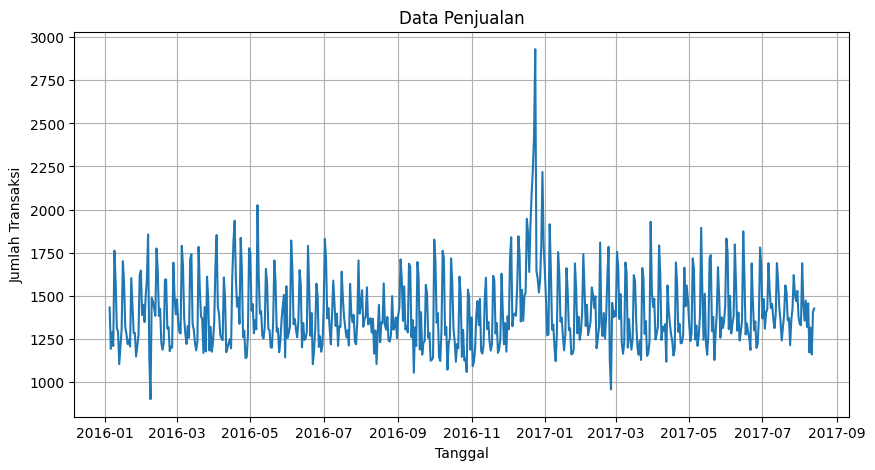

In [ ]:
# plot data penjualan
plt.figure(figsize=(10, 5))
plt.plot(df_transactions['transactions'])
plt.title('Data Penjualan')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Transaksi')
plt.grid(True)
plt.show()

<Axes: >

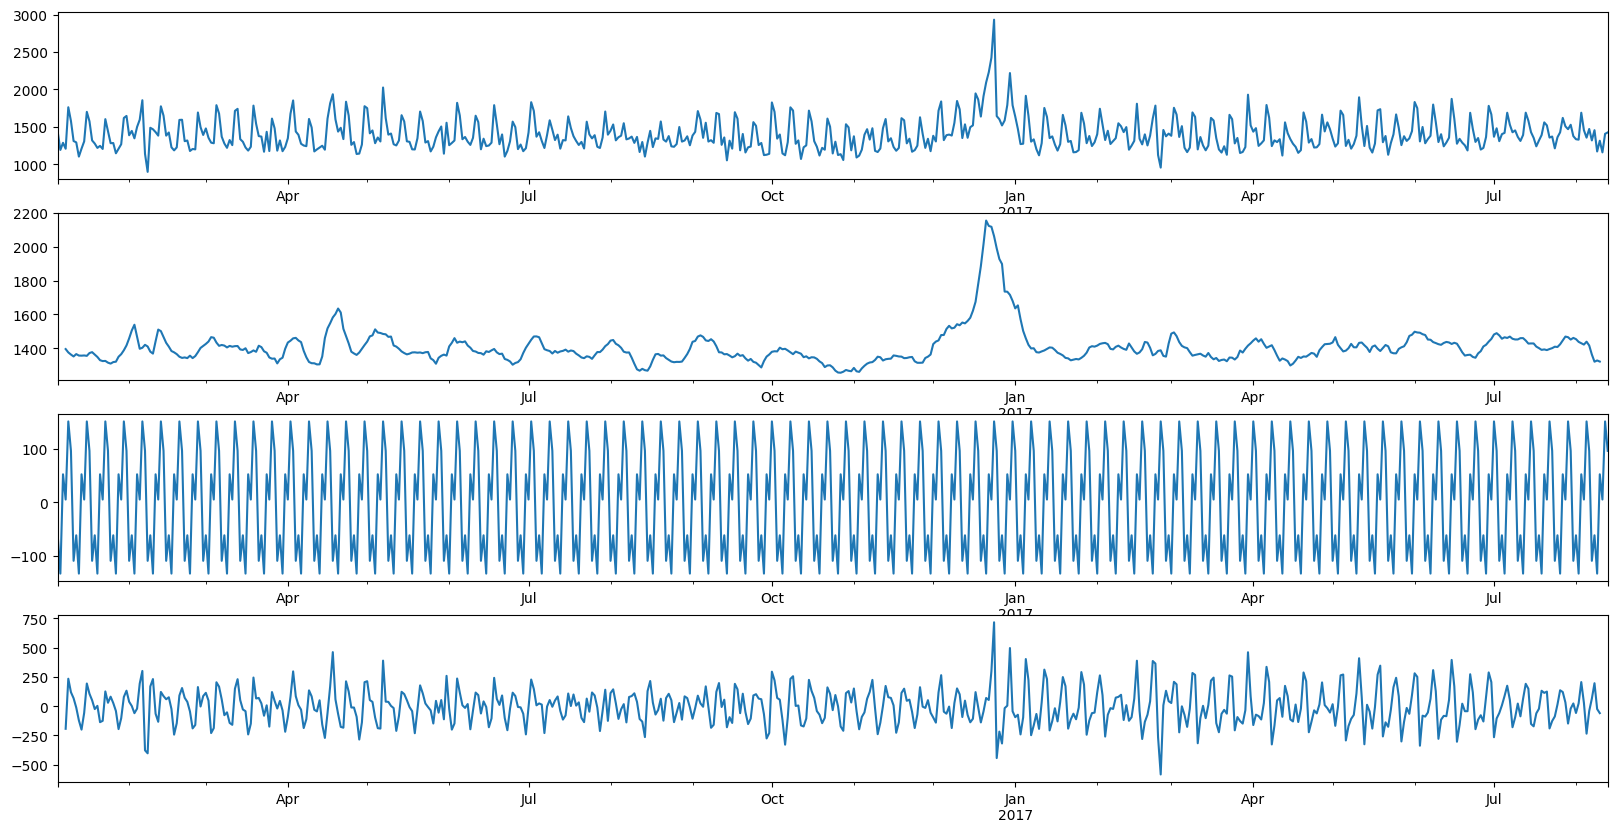

In [ ]:
# Decompose data transactions
plot_decompose = seasonal_decompose(df_transactions['transactions'], model='additive')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10))
plot_decompose.observed.plot(ax=ax1)
plot_decompose.trend.plot(ax=ax2)
plot_decompose.seasonal.plot(ax=ax3)
plot_decompose.resid.plot(ax=ax4)

# Uji Diagnostik

## Uji Stasioneritas

### Augmented Dickey-Fuller Test

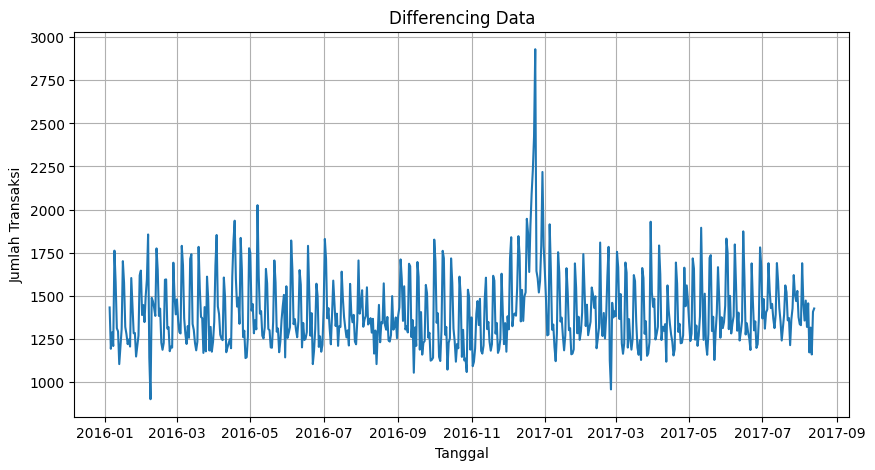

In [ ]:
# Plot nilai df_transactions['transactions'].diff().dropna()
plt.figure(figsize=(10, 5))
plt.plot(df_transactions['transactions'].dropna())
plt.title('Differencing Data')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Transaksi')
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_transactions['transactions'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.227369
p-value: 0.000592


Nilai p-value kurang dari 0.05, yang berarti data adalah sudah cukup stasioner

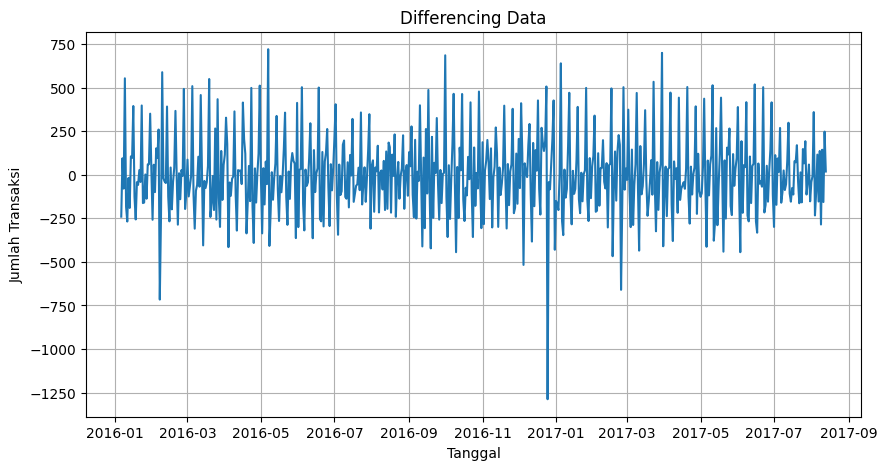

In [ ]:
# Plot nilai df_transactions['transactions'].diff().dropna()
plt.figure(figsize=(10, 5))
plt.plot(df_transactions['transactions'].diff().dropna())
plt.title('Differencing Data')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Transaksi')
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_transactions['transactions'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.422586
p-value: 0.000000


## Uji Residual

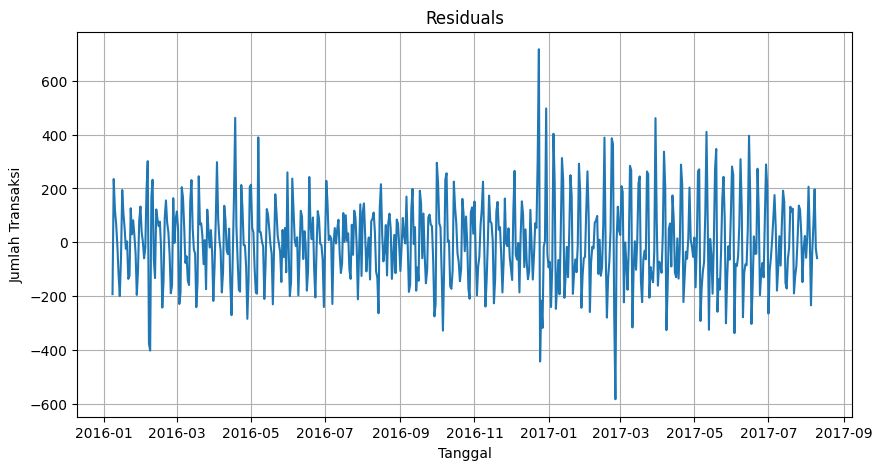

In [ ]:
# Residuals diagnostics
residuals = plot_decompose.resid.dropna()
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Transaksi')
plt.grid(True)
plt.show()

Walaupun residual memiliki nilai cukup besar, namun melihat grafiknya, residual sudah cukup baik

# Analisis Model ARIMA

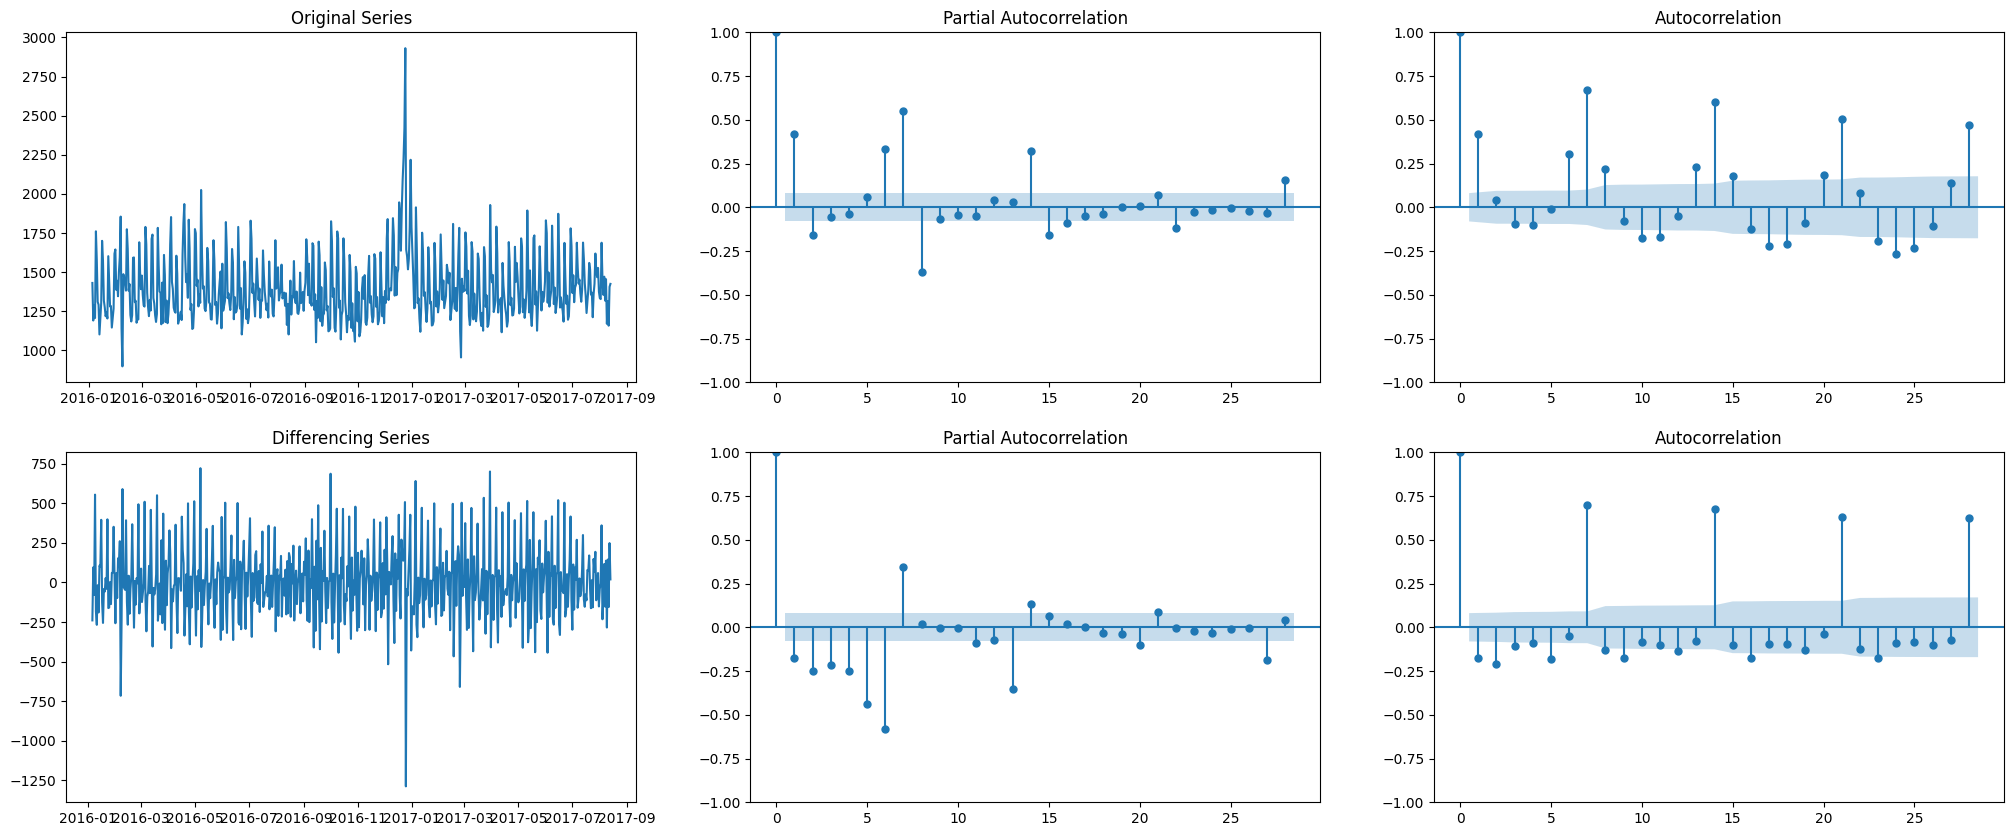

In [ ]:
# Plot ACF dan PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 3, figsize=(25, 10))

ax[0, 0].set_title('Original Series')
ax[0, 0].plot(df_transactions['transactions'])
ax[0, 1] = plot_pacf(df_transactions['transactions'], ax=ax[0, 1])
ax[0, 2] = plot_acf(df_transactions['transactions'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(df_transactions['transactions'].diff().dropna())
ax[1, 1] = plot_pacf(df_transactions['transactions'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_acf(df_transactions['transactions'].diff().dropna(), ax=ax[1, 2])



plt.show()


Dari PACF, kita bisa mengambilkan nilai AR(p) = 6,<br>
Dari ACF, kita bisa mengambilkan nilai MA(q) = 1,<br>
Dari hasil uji diagnostik, kita bisa mengambilkan nilai d = 0, <br>
Dari PACF, kita bisa mengambil kesimpulan seasonal = 7  

# Modeling

In [ ]:
# Out-of-Time Cross validation
train = df_transactions['transactions'][:len(df_transactions)-30]
test = df_transactions['transactions'][len(df_transactions)-30:]

In [ ]:
train

,transactions
2016-01-05,1431
2016-01-06,1191
2016-01-07,1286
2016-01-08,1207
2016-01-09,1761
...,...
2017-07-10,1365
2017-07-11,1311
2017-07-12,1390
2017-07-13,1689


In [ ]:
test

,transactions
2017-07-15,1428
2017-07-16,1352
2017-07-17,1239
2017-07-18,1317
2017-07-19,1389
2017-07-20,1559
2017-07-21,1519
2017-07-22,1356
2017-07-23,1370
2017-07-24,1212


## ARIMA (p,d,q)

In [ ]:
# Seasoaonal ARIMA Model
model1 = ARIMA(train, order=(6,0,1), seasonal_order=(6,0,1,7))
model_fit1 = model1.fit()
print(model_fit1.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                    
Dep. Variable:                    transactions   No. Observations:                  557
Model:             ARIMA(6, 0, 1)x(6, 0, 1, 7)   Log Likelihood               -3493.691
Date:                         Thu, 23 Jan 2025   AIC                           7019.383
Time:                                 07:33:47   BIC                           7088.544
Sample:                             01-05-2016   HQIC                          7046.395
                                  - 07-14-2017                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1404.6208    152.734      9.197      0.000    1105.268    1703.974
ar.L1         -0.4443      0.048     -9.254      0.000     

Nilai yang penting :
- AIC (Akaike Information Criterion): Nilai AIC digunakan untuk membandingkan kebaikan model, di mana nilai yang lebih rendah menunjukkan model yang lebih baik. Jadi, semakin kecil nilai AIC, semakin baik modelnya.

- BIC (Bayesian Information Criterion): Seperti AIC, nilai BIC juga digunakan untuk membandingkan kebaikan model, di mana nilai yang lebih rendah menunjukkan model yang lebih baik. Jadi, semakin kecil nilai BIC, semakin baik modelnya.

- Ljung-Box (Q): Uji Ljung-Box digunakan untuk mengevaluasi apakah ada autocorrelation pada residual model. P-value yang tinggi (misalnya, > 0.05) menunjukkan tidak adanya bukti signifikan untuk autocorrelation residual. Jadi, Anda ingin memastikan bahwa p-value untuk uji ini tinggi.

- Jarque-Bera (JB): Uji Jarque-Bera digunakan untuk mengevaluasi apakah residual model memiliki distribusi normal. P-value yang tinggi (misalnya, > 0.05) menunjukkan tidak adanya bukti signifikan untuk ketidaknormalan pada residual. Jadi, Anda ingin memastikan bahwa p-value untuk uji ini tinggi.

Dengan demikian, Anda ingin melihat bahwa nilai AIC dan BIC semakin kecil, sedangkan p-value untuk uji Ljung-Box dan Jarque-Bera semakin besar. Hal ini menunjukkan bahwa model Anda memiliki kualitas yang lebih baik.

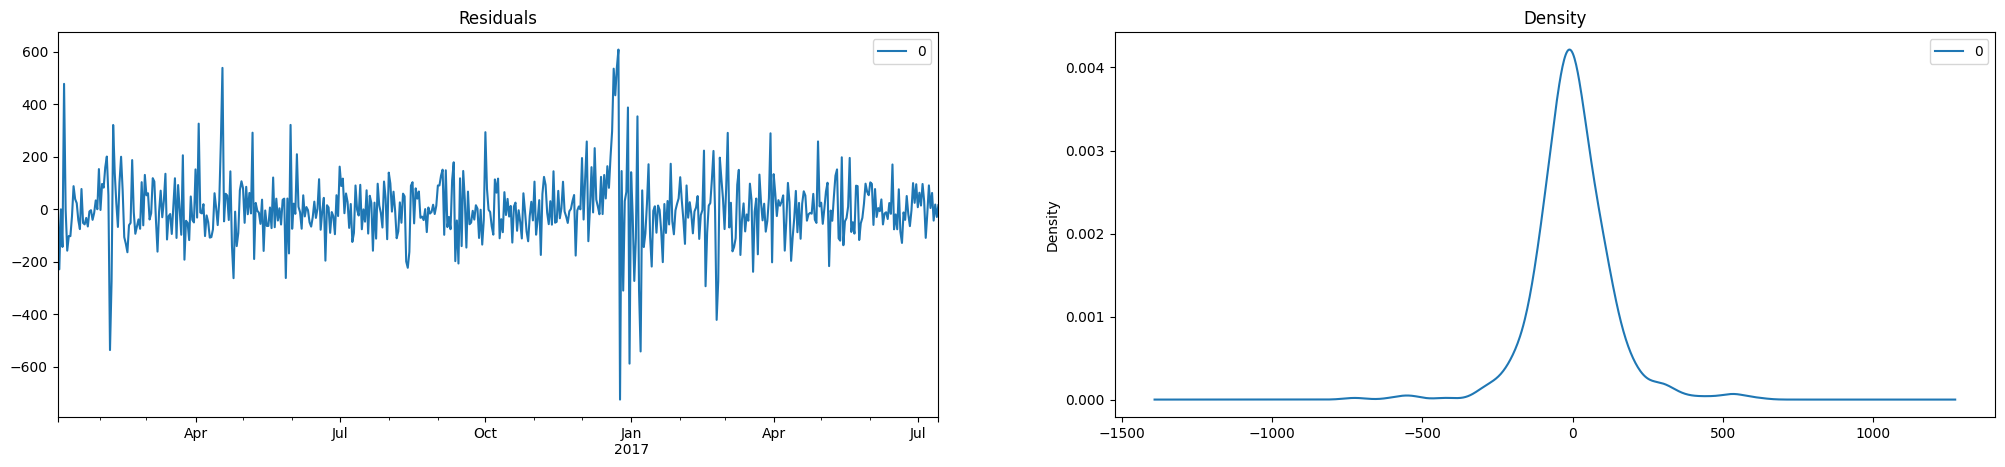

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit1.resid)
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


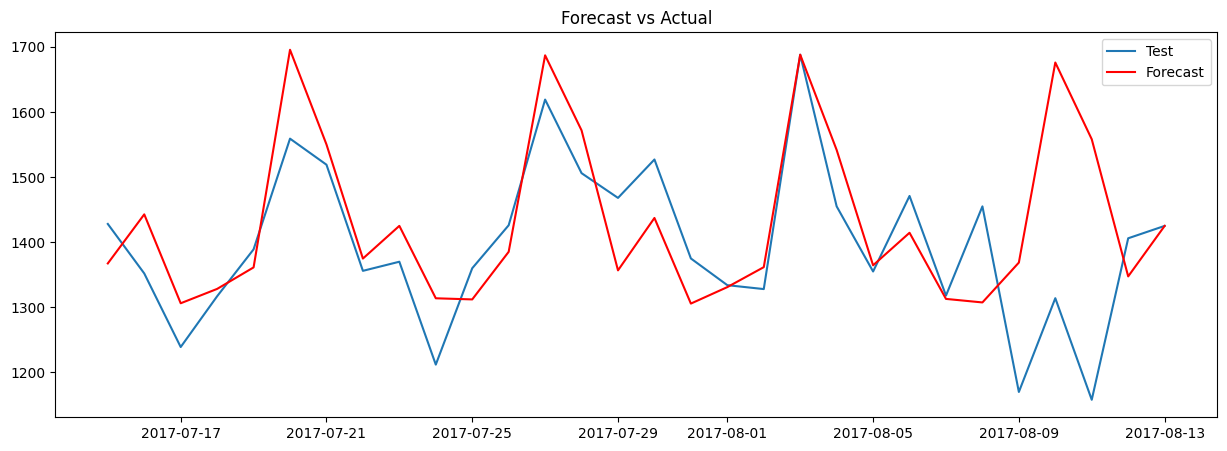

In [ ]:
# Prediction
forecast = model_fit1.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
forecast.index = test.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast', color='r')
plt.legend()

In [ ]:
# check forecast row
forecastARIMA = pd.DataFrame({'test': test, 'forecast': forecast})
forecastARIMA

,test,forecast
2017-07-15,1428,1367.379774
2017-07-16,1352,1442.735688
2017-07-17,1239,1306.215673
2017-07-18,1317,1328.266114
2017-07-19,1389,1361.277565
2017-07-20,1559,1695.479483
2017-07-21,1519,1550.130459
2017-07-22,1356,1374.856844
2017-07-23,1370,1425.067693
2017-07-24,1212,1313.858497


# Model LSTM

In [ ]:
# Split data
# Scalling

# train.reset_index()

scaler = MinMaxScaler()
train.head(), test.head()

(2016-01-05    1431
 2016-01-06    1191
 2016-01-07    1286
 2016-01-08    1207
 2016-01-09    1761
 Freq: D, Name: transactions, dtype: int64,
 2017-07-15    1428
 2017-07-16    1352
 2017-07-17    1239
 2017-07-18    1317
 2017-07-19    1389
 Freq: D, Name: transactions, dtype: int64)

In [ ]:
trainLSTM = train.values.reshape(-1, 1)
testLSTM = test.values.reshape(-1, 1)

scaler.fit(trainLSTM)
# reshape the data
scaled_train = scaler.transform(trainLSTM)
scaled_test = scaler.transform(testLSTM)

In [ ]:
scaled_train[:10]

array([[0.26217413],
       [0.14412199],
       [0.19085096],
       [0.15199213],
       [0.42449582],
       [0.33448106],
       [0.20265617],
       [0.19380226],
       [0.10034432],
       [0.15248401]])

In [ ]:
scaled_test[:10]

array([[0.26069848],
       [0.2233153 ],
       [0.16773242],
       [0.20609936],
       [0.241515  ],
       [0.32513527],
       [0.30545991],
       [0.22528283],
       [0.23216921],
       [0.15445155]])

In [ ]:
# We do the same thing, but now instead for 12 months
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

# define model
model = Sequential()
model.add(LSTM(50, input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

n_input = 7 mungkin dipilih karena data memiliki pola mingguan

In [ ]:
# fit model
model.fit(generator, epochs=50)

Epoch 1/50
 43/550 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0195

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


550/550 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0126
Epoch 2/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0098
Epoch 3/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0068
Epoch 4/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0064
Epoch 5/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0068
Epoch 6/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0075
Epoch 7/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0059
Epoch 8/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0065
Epoch 9/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 10/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0058
Epoch 11/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0049
Epoch 12/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0074
Epoch 13/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0053
Epoch 14/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0062
Epoch 15/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0049


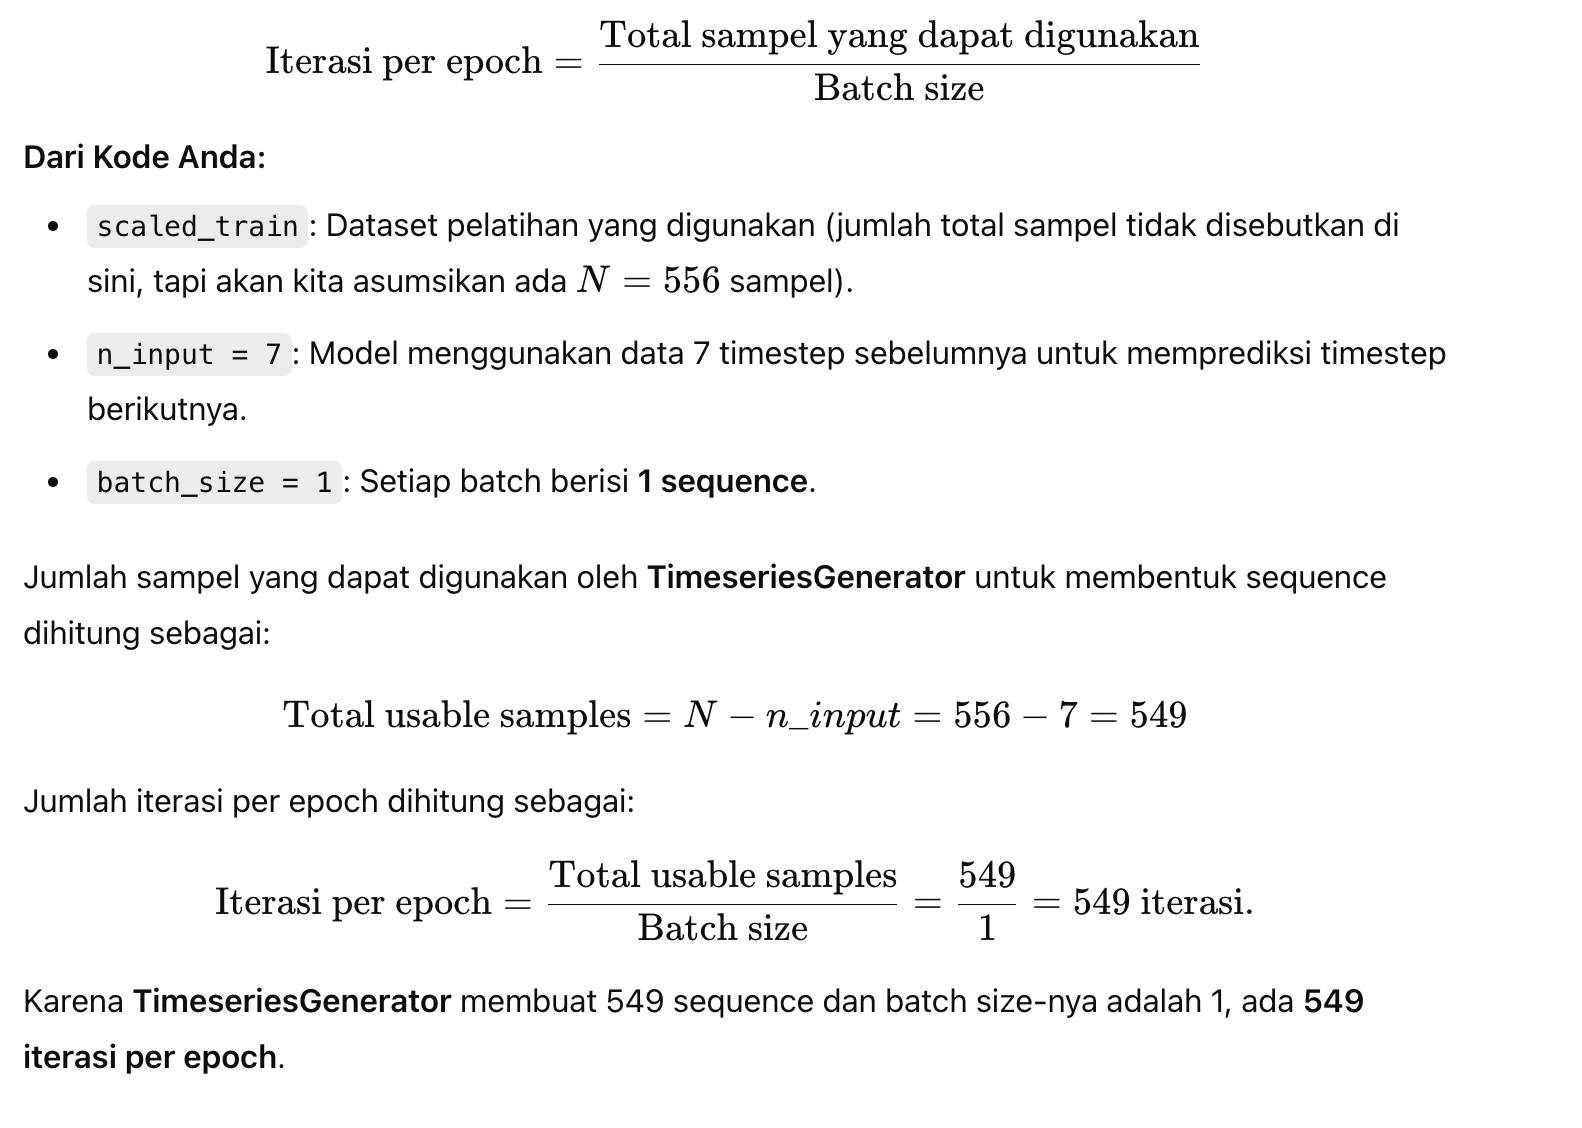

In [ ]:
trainPredict = model.predict(scaled_train)
testPredict = model.predict(scaled_test)

# Reshape trainPredict and testPredict for plotting
trainPredict = trainPredict.reshape(-1, 1)
testPredict = testPredict.reshape(-1, 1)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(scaled_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(scaled_test)

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(30, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(30, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
(30, 1)
(30, 1)


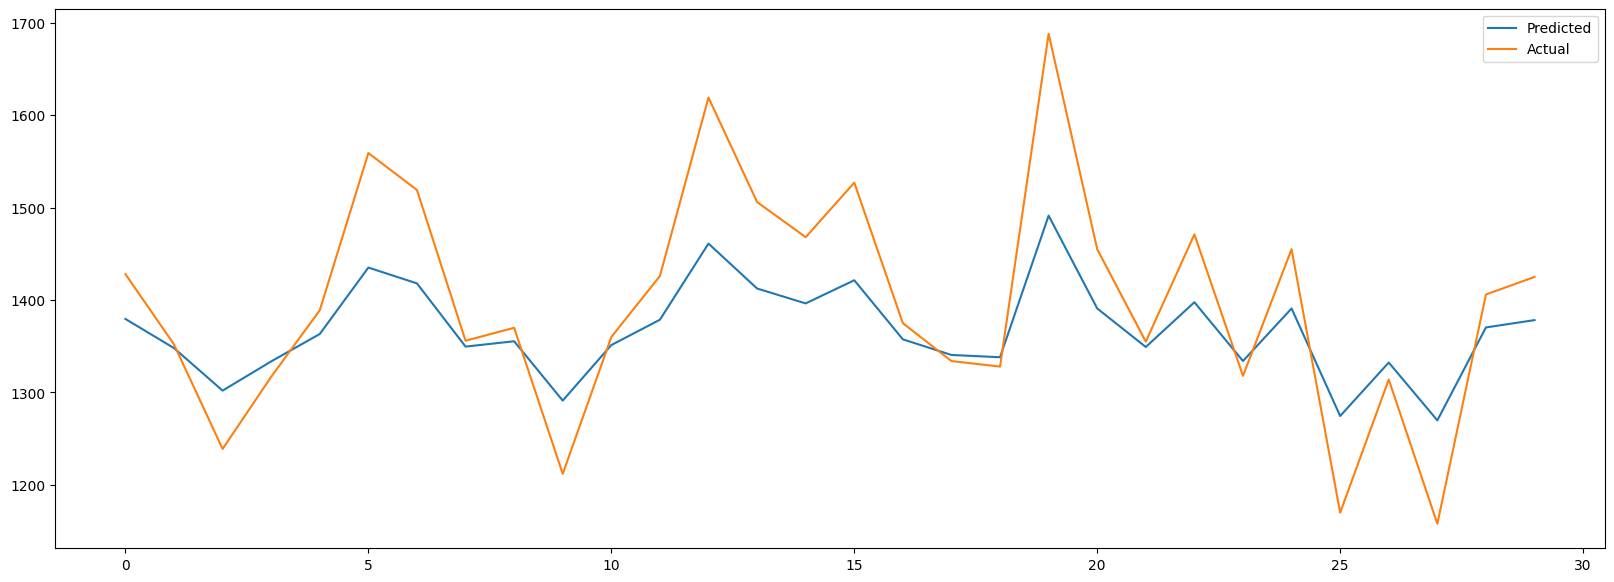

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [ ]:
# Input into pandas dataframe, test as index and plot_predicted as the column
# Reshape the data plot_predicted
plot_predicted = plot_predicted.reshape(30,)

forecastLSTM = pd.DataFrame({'test': test, 'forecast': plot_predicted}, index=test.index)
forecastLSTM

,test,forecast
2017-07-15,1428,1379.549316
2017-07-16,1352,1347.992432
2017-07-17,1239,1302.043457
2017-07-18,1317,1333.634888
2017-07-19,1389,1363.291138
2017-07-20,1559,1435.132568
2017-07-21,1519,1418.004272
2017-07-22,1356,1349.640381
2017-07-23,1370,1355.419678
2017-07-24,1212,1291.240356


# Uji Metrik

In [ ]:
# RSquared forecastARIMA and forecastLSTM
r2_scoreARIMA = metrics.r2_score(forecastARIMA['test'], forecastARIMA['forecast'])
print('R2 Score ARIMA:', r2_scoreARIMA)
r2_scoreLSTM = metrics.r2_score(forecastLSTM['test'], forecastLSTM['forecast'])
print('R2 Score LSTM:', r2_scoreLSTM)

R2 Score ARIMA: -0.06656173459735837
R2 Score LSTM: 0.5983293056488037


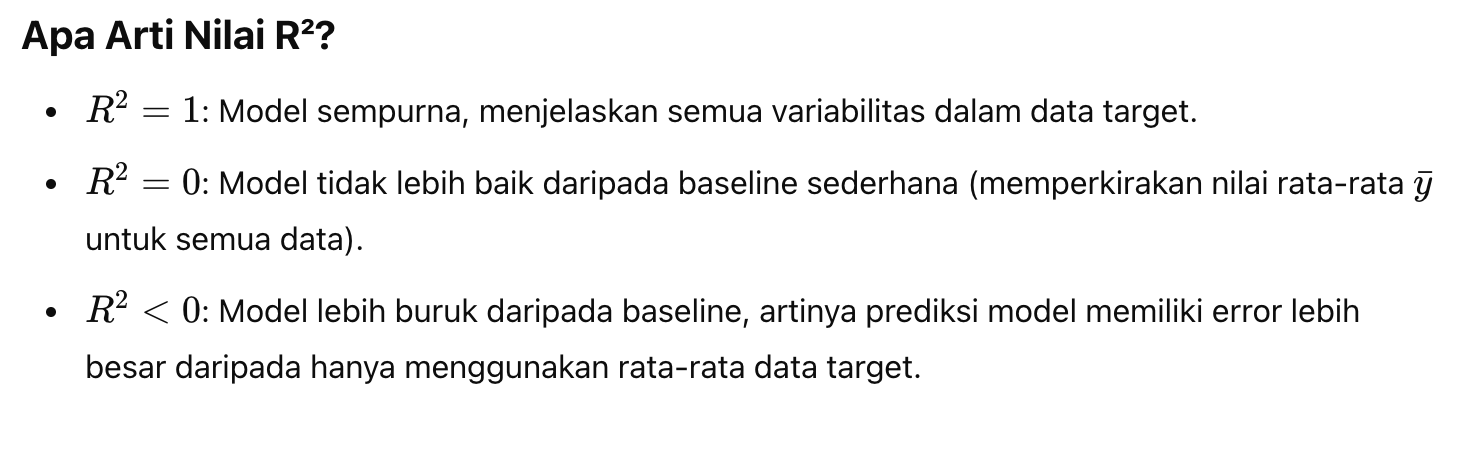

In [ ]:
# MSE
mseARIMA = mean_squared_error(forecastARIMA['test'], forecastARIMA['forecast'])
print('MSE ARIMA:', mseARIMA)
mseLSTM = mean_squared_error(forecastLSTM['test'], forecastLSTM['forecast'])
print('MSE LSTM:', mseLSTM)

MSE ARIMA: 15216.172905680258
MSE LSTM: 5730.4609375


In [ ]:
# RMSE
rmse = np.sqrt(mseARIMA)
print('RMSE ARIMA:', rmse)
rmse = np.sqrt(mseLSTM)
print('RMSE LSTM:', rmse)

RMSE ARIMA: 123.35385241523775
RMSE LSTM: 75.69980804136824


In [ ]:
# MAE
maeARIMA = metrics.mean_absolute_error(forecastARIMA['test'], forecastARIMA['forecast'])
print('MAE ARIMA:', maeARIMA)
maeLSTM = metrics.mean_absolute_error(forecastLSTM['test'], forecastLSTM['forecast'])
print('MAE LSTM:', maeLSTM)

MAE ARIMA: 81.82828721498991
MAE LSTM: 57.97039031982422


In [ ]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mapeARIMA = mean_absolute_percentage_error(forecastARIMA['test'], forecastARIMA['forecast'])
print('MAPE ARIMA:', mapeARIMA)
mapeLSTM = mean_absolute_percentage_error(forecastLSTM['test'], forecastLSTM['forecast'])
print('MAPE LSTM:', mapeLSTM)

MAPE ARIMA: 6.1438230330023815
MAPE LSTM: 4.05705495836223


In [ ]:
# MASE
def mean_absolute_scaled_error(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

maseARIMA = mean_absolute_scaled_error(train, test, forecastARIMA['forecast'])
print('MASE ARIMA:', maseARIMA)
maseLSTM = mean_absolute_scaled_error(train, test, forecastLSTM['forecast'])
print('MASE LSTM:', maseLSTM)

MASE ARIMA: 0.4629888741035586
MASE LSTM: 0.32799960042563675


In [ ]:
# # Calculate metrics for ARIMA
# r2_scoreARIMA = metrics.r2_score(forecastARIMA['test'], forecastARIMA['forecast'])
# mseARIMA = mean_squared_error(forecastARIMA['test'], forecastARIMA['forecast'])
# rmseARIMA = np.sqrt(mseARIMA)
# maeARIMA = metrics.mean_absolute_error(forecastARIMA['test'], forecastARIMA['forecast'])
# mapeARIMA = mean_absolute_percentage_error(forecastARIMA['test'], forecastARIMA['forecast'])
# maseARIMA = mean_absolute_scaled_error(train, forecastARIMA['test'], forecastARIMA['forecast'])

# # Calculate metrics for LSTM
# r2_scoreLSTM = metrics.r2_score(forecastLSTM['test'], forecastLSTM['forecast'])
# mseLSTM = mean_squared_error(forecastLSTM['test'], forecastLSTM['forecast'])
# rmseLSTM = np.sqrt(mseLSTM)
# maeLSTM = metrics.mean_absolute_error(forecastLSTM['test'], forecastLSTM['forecast'])
# mapeLSTM = mean_absolute_percentage_error(forecastLSTM['test'], forecastLSTM['forecast'])
# maseLSTM = mean_absolute_scaled_error(train, forecastLSTM['test'], forecastLSTM['forecast'])

# Create a DataFrame to display the results
results = pd.DataFrame({
    'Metric': ['R2 Score', 'MSE', 'RMSE', 'MAE', 'MAPE', 'MASE'],
    'ARIMA': [r2_scoreARIMA, mseARIMA, rmseARIMA, maeARIMA, mapeARIMA, maseARIMA],
    'LSTM': [r2_scoreLSTM, mseLSTM, rmseLSTM, maeLSTM, mapeLSTM, maseLSTM]
})

results

,Metric,ARIMA,LSTM
0,R2 Score,-0.066562,0.598329
1,MSE,15216.172906,5730.460938
2,RMSE,123.353852,75.699808
3,MAE,81.828287,57.970390
4,MAPE,6.143823,4.057055
5,MASE,0.462989,0.328000
